In [ ]:
Выполнил студент группы ББМО-01-23: Буланов Андрей Алексеевич

Цель работы:

1) Загрузить ранее обученную модель на датасете MNIST.

2) Изучить теоретические основы атаки PGD.

3) Реализовать атаку PGD с помощью фреймворка Foolbox.

4) Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

In [1]:
#Устанвока библеотеки foolbox

!pip install foolbox


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Импорт всех необходимых библеотек

import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [7]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Точность теста на чистых изображениях: {test_acc:.2%}')

Точность теста на чистых изображениях: 97.59%


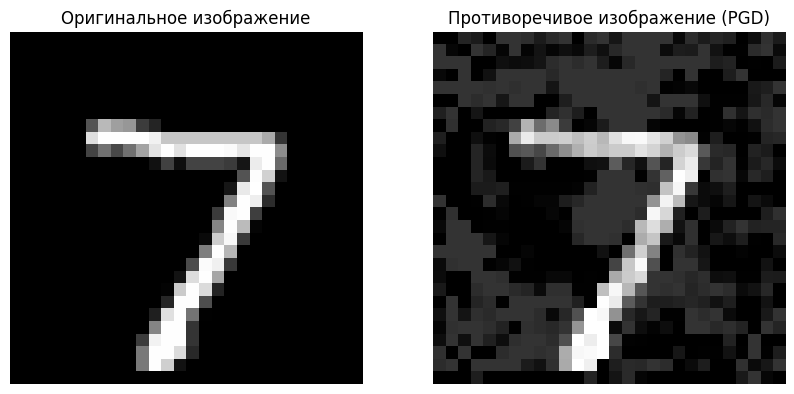

In [21]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, _ = attack(fmodel, image, label[None], epsilons=0.2)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show() 

In [24]:
# Атака на весь тестовый набор
adversarial_images = []
# Обработка изображений
for i in range(len(test_images)):
    img = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    lbl = tf.convert_to_tensor(np.argmax(test_labels[i]), dtype=tf.int64)
    adv, _, _ = attack(fmodel, img, lbl[None], epsilons=0.05)
    adversarial_images.append(adv)

# Конвертация 
adversarial_images = tf.concat(adversarial_images, axis=0)


In [25]:
# Оценка на противоречивых данных
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels, verbose=0)
print(f'Точность на состязательных примерах (PGD): {adversarial_acc:.2%}')

Точность на состязательных примерах (PGD): 51.81%


Вывод:

Точность модели на противоречивых примерах, созданных с помощью атаки Projected Gradient Descent, снизилась примерно в два раза ~51,81%. Это демонстрирует существенную уязвимость модели перед PGD атаками